In [1]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras import callbacks
import os
from pathlib import Path
import cv2
import string
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt

#Init main values ,ascii_lowercase ,ascii_uppercase
symbols = string.ascii_uppercase + "0123456789" # All symbols captcha can contain
num_symbols = len(symbols)


In [2]:
print(symbols)
print(num_symbols)

ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789
36


### 일부 이미지 시각화하기
데이터 증가를 이해하기 위해 일부 학습용 이미지를 시각화해보겠습니다.

Number of images found:  257
Shape of image:  (60, 160, 3)
Shape of image:  (60, 160, 3)
Shape of image:  (60, 160, 3)
Shape of image:  (60, 160, 3)


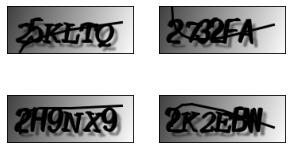

In [3]:
data_path = 'data/giro'
# data_path = 'captcha_images_v2'
# Path to the data directory
# data_dir = Path("../input/captcha-version-2-images/samples/")
# data_dir = Path('captcha_images_v2')
data_dir = Path(data_path)
# data_dir = Path('data/giro')



# Get list of all the images
images = list(data_dir.glob("*.png"))
print("Number of images found: ", len(images))


# Let's take a look at some samples first. 
# Always look at your data!
sample_images = images[:4]

_,ax = plt.subplots(2,2, figsize=(5,3))
for i in range(4):
    img = cv2.imread(str(sample_images[i]))
    print("Shape of image: ", img.shape)
    ax[i//2, i%2].imshow(img)
    ax[i//2, i%2].axis('off')
plt.show()

In [4]:
img_shape = (60, 160, 1)

In [5]:
def create_model():
    img = layers.Input(shape=img_shape) # Get image as an input and process it through some Convs
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 100x25
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 50x13
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(padding='same')(bn)  # 25x7
    
    # Get flattened vector and make 5 branches from it. Each branch will predict one letter
    flat = layers.Flatten()(mp3)
    outs = []
    for _ in range(5):
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)
        res = layers.Dense(num_symbols, activation='sigmoid')(drop)

        outs.append(res)
    
    # Compile model and return it
    model = Model(img, outs)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    return model

Importing Data

In [6]:
def preprocess_data():
    n_samples = len(os.listdir(data_path))
    X = np.zeros((n_samples, 60, 160, 1)) #1070*50*200
    y = np.zeros((5, n_samples, num_symbols)) #5*1070*36

    for i, pic in enumerate(os.listdir(data_path)):
        # Read image as grayscale
        img = cv2.imread(os.path.join(data_path, pic), cv2.IMREAD_GRAYSCALE)
        pic_target = pic[:-4]
        if len(pic_target) < 6:
            # Scale and reshape image
            img = img / 255.0
            img = np.reshape(img, (60, 160, 1))
            # Define targets and code them using OneHotEncoding
            targs = np.zeros((5, num_symbols))
            for j, l in enumerate(pic_target):
                ind = symbols.find(l)
                targs[j, ind] = 1
            X[i] = img
            y[:, i] = targs
    
    # Return final data
    return X, y

X, y = preprocess_data()
X_train, y_train = X[:210], y[:, :210]
X_test, y_test = X[210:], y[:, 210:]
print(str(len(X_train)) + " training samples")
print(str(len(X_test)) + " validation samples")
print(str(len(X_train)+len(X_test)) + " total samples")


210 training samples
47 validation samples
257 total samples


In [7]:
model=create_model();
model.summary();

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 160, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 60, 160, 16)  160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 30, 80, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 30, 80, 32)   4640        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [8]:
#model = create_model()
hist = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]], batch_size=32, epochs=30,verbose=1, validation_split=0.2)

Epoch 1/30
6/6 [==============================] - 5s 127ms/step - loss: 0.0000e+00 - dense_1_loss: 0.0000e+00 - dense_3_loss: 0.0000e+00 - dense_5_loss: 0.0000e+00 - dense_7_loss: 0.0000e+00 - dense_9_loss: 0.0000e+00 - dense_1_accuracy: 1.0000 - dense_3_accuracy: 1.0000 - dense_5_accuracy: 1.0000 - dense_7_accuracy: 1.0000 - dense_9_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_dense_1_loss: 0.0000e+00 - val_dense_3_loss: 0.0000e+00 - val_dense_5_loss: 0.0000e+00 - val_dense_7_loss: 0.0000e+00 - val_dense_9_loss: 0.0000e+00 - val_dense_1_accuracy: 1.0000 - val_dense_3_accuracy: 1.0000 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 1.0000 - val_dense_9_accuracy: 1.0000
Epoch 2/30
6/6 [==============================] - 0s 19ms/step - loss: 0.0000e+00 - dense_1_loss: 0.0000e+00 - dense_3_loss: 0.0000e+00 - dense_5_loss: 0.0000e+00 - dense_7_loss: 0.0000e+00 - dense_9_loss: 0.0000e+00 - dense_1_accuracy: 1.0000 - dense_3_accuracy: 1.0000 - dense_5_accuracy: 1.0000 - dense_7_accura

Epoch 13/30
6/6 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - dense_1_loss: 0.0000e+00 - dense_3_loss: 0.0000e+00 - dense_5_loss: 0.0000e+00 - dense_7_loss: 0.0000e+00 - dense_9_loss: 0.0000e+00 - dense_1_accuracy: 1.0000 - dense_3_accuracy: 1.0000 - dense_5_accuracy: 1.0000 - dense_7_accuracy: 1.0000 - dense_9_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_dense_1_loss: 0.0000e+00 - val_dense_3_loss: 0.0000e+00 - val_dense_5_loss: 0.0000e+00 - val_dense_7_loss: 0.0000e+00 - val_dense_9_loss: 0.0000e+00 - val_dense_1_accuracy: 1.0000 - val_dense_3_accuracy: 1.0000 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 1.0000 - val_dense_9_accuracy: 1.0000
Epoch 14/30
6/6 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - dense_1_loss: 0.0000e+00 - dense_3_loss: 0.0000e+00 - dense_5_loss: 0.0000e+00 - dense_7_loss: 0.0000e+00 - dense_9_loss: 0.0000e+00 - dense_1_accuracy: 1.0000 - dense_3_accuracy: 1.0000 - dense_5_accuracy: 1.0000 - dense_7_accur

Epoch 25/30
6/6 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - dense_1_loss: 0.0000e+00 - dense_3_loss: 0.0000e+00 - dense_5_loss: 0.0000e+00 - dense_7_loss: 0.0000e+00 - dense_9_loss: 0.0000e+00 - dense_1_accuracy: 1.0000 - dense_3_accuracy: 1.0000 - dense_5_accuracy: 1.0000 - dense_7_accuracy: 1.0000 - dense_9_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_dense_1_loss: 0.0000e+00 - val_dense_3_loss: 0.0000e+00 - val_dense_5_loss: 0.0000e+00 - val_dense_7_loss: 0.0000e+00 - val_dense_9_loss: 0.0000e+00 - val_dense_1_accuracy: 1.0000 - val_dense_3_accuracy: 1.0000 - val_dense_5_accuracy: 1.0000 - val_dense_7_accuracy: 1.0000 - val_dense_9_accuracy: 1.0000
Epoch 26/30
6/6 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - dense_1_loss: 0.0000e+00 - dense_3_loss: 0.0000e+00 - dense_5_loss: 0.0000e+00 - dense_7_loss: 0.0000e+00 - dense_9_loss: 0.0000e+00 - dense_1_accuracy: 1.0000 - dense_3_accuracy: 1.0000 - dense_5_accuracy: 1.0000 - dense_7_accur

In [9]:
# Define function to predict captcha
def predict(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = img / 255.0
    else:
        print("Not detected");
    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))
    ans = np.reshape(res, (5, 36))
    l_ind = []
    probs = []
    for a in ans:
        l_ind.append(np.argmax(a))
        #probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += symbols[l]
    return capt#, sum(probs) / 5


In [10]:
score= model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]],verbose=1)
print('='*100)
print('Test Loss and accuracy:', score)

2/2 [==============================] - 0s 76ms/step - loss: 0.0000e+00 - dense_1_loss: 0.0000e+00 - dense_3_loss: 0.0000e+00 - dense_5_loss: 0.0000e+00 - dense_7_loss: 0.0000e+00 - dense_9_loss: 0.0000e+00 - dense_1_accuracy: 1.0000 - dense_3_accuracy: 1.0000 - dense_5_accuracy: 1.0000 - dense_7_accuracy: 1.0000 - dense_9_accuracy: 1.0000
Test Loss and accuracy: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [11]:
# Check model on some samples
model.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])
print('='*100)
print(predict('data/giro/ZXLQSG.png'))
print(predict('data/giro/UYN54A.png'))
print(predict('data/giro/FLDUGU.png'))
print(predict('data/giro/K7TABR.png'))
print(predict('data/giro/8JGLWU.png'))

2/2 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - dense_1_loss: 0.0000e+00 - dense_3_loss: 0.0000e+00 - dense_5_loss: 0.0000e+00 - dense_7_loss: 0.0000e+00 - dense_9_loss: 0.0000e+00 - dense_1_accuracy: 1.0000 - dense_3_accuracy: 1.0000 - dense_5_accuracy: 1.0000 - dense_7_accuracy: 1.0000 - dense_9_accuracy: 1.0000
97AFT
9RAFW
9RAFT
97AFT
9RAFT


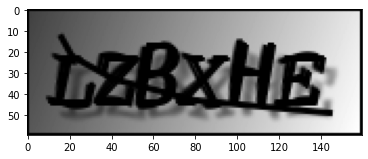

In [12]:
#Lets test an unknown captcha
#preview
%matplotlib inline 
import matplotlib.pyplot as plt
img=cv2.imread('data/giro_test/LZBXHE.png',cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [13]:
#Lets Predict By Model
print("Predicted Captcha =",predict('data/giro_test/LZBXHE.png'))

Predicted Captcha = 9RAFM
